PREDICTING AVERAGING GDP GROWTH WITH PROPORTION

In [1]:
import pandas as pd
import requests
import time
import numpy as np

new_df_w = pd.read_csv("Final.csv")
new_df_w

,Country Name,Annual GDP 2017,GDP Growth 2017,Annual GDP 2018,GDP Growth 2018,Annual GDP 2019,GDP Growth 2019,Series Name,Tourism Expenditure 2017,Tourism Expenditure 2018,...,Consumer Spending 2018,Consumer Spending 2019,% TE Growth 17-18,% TE Growth 18-19,Overall TE Growth,% CS Growth 17-18,% CS Growth 18-19,Overall CS Growth,Proportion TE/CS,Average Growth GDP
0,United States,1.947730e+13,2.2,2.053310e+13,2.9,2.138100e+13,2.3,"International tourism, expenditures (current US$)",1.582870e+11,1.768180e+11,...,1.680000e+13,1.740000e+13,-10.480268,-4.976918,5.503349,5.000000,3.571429,-1.428571,-3.852345,2.433333
1,Germany,3.689547e+12,2.7,3.976246e+12,1.0,3.888655e+12,0.6,"International tourism, expenditures (current US$)",9.716300e+10,1.035020e+11,...,2.860000e+12,2.810000e+12,-6.124519,2.243384,8.367903,7.518797,-1.748252,-9.267049,-0.902974,2.133333
2,France,2.594235e+12,2.3,2.792223e+12,1.9,2.729171e+12,1.8,"International tourism, expenditures (current US$)",5.378700e+10,5.913100e+10,...,2.150000e+12,2.090000e+12,-9.037561,-1.037640,7.999921,6.965174,-2.790698,-9.755872,-0.820011,2.166667
3,Japan,4.930837e+12,1.7,5.040885e+12,0.6,5.120310e+12,-0.4,"International tourism, expenditures (current US$)",2.577400e+10,2.809700e+10,...,3.750000e+12,3.820000e+12,-8.267787,-3.599122,4.668665,2.739726,1.866667,-0.873059,-5.347477,1.333333
4,Italy,1.961104e+12,1.7,2.092881e+12,0.9,2.011507e+12,0.5,"International tourism, expenditures (current US$)",3.481900e+10,3.764400e+10,...,1.650000e+12,1.580000e+12,-7.504516,-0.696423,6.808093,6.451613,-4.242424,-10.694037,-0.636625,1.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Vanuatu,8.800000e+08,6.3,9.290000e+08,2.9,9.300000e+08,3.2,"International tourism, expenditures (current US$)",1.900000e+07,2.100000e+07,...,6.940408e+08,7.126577e+08,-9.523810,-34.375000,-24.851190,-0.634670,2.682400,3.317070,-7.491910,5.166667
118,Samoa,8.850000e+08,1.4,8.780000e+08,-0.6,9.130000e+08,4.5,"International tourism, expenditures (current US$)",3.900000e+06,4.100000e+06,...,7.115352e+08,7.373096e+08,-4.878044,-21.153845,-16.275801,-1.249422,3.622353,4.871775,-3.340836,0.733333
119,South Africa,3.813170e+11,1.4,4.039910e+11,0.8,3.884460e+11,0.2,"International tourism, expenditures (current US$)",6.068000e+09,6.348000e+09,...,3.370000e+11,3.250000e+11,-4.410838,8.216843,12.627681,7.324841,-3.560831,-10.885672,-1.160028,1.200000
120,Zambia,2.587400e+10,4.1,2.631200e+10,3.5,2.330900e+10,1.4,"International tourism, expenditures (current US$)",4.100000e+08,4.780000e+08,...,1.517567e+10,1.396964e+10,-14.225941,-6.457926,7.768016,-3.375414,-7.947153,-4.571739,-1.699138,3.900000


<Axes: >

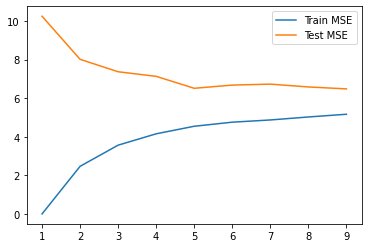

In [2]:
## Determining the right value of K for KRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

results = []

X_train= new_df_w[["Proportion TE/CS"]]
y_train= new_df_w["Average Growth GDP"]

col_transformer = make_column_transformer((StandardScaler(), ["Proportion TE/CS"]))

kvals = range(1,10)
for k in kvals:
  pipeline = make_pipeline(
      col_transformer,
      KNeighborsRegressor(n_neighbors=k,metric="euclidean")
  )
  pipeline.fit(X_train,y_train)
  y_preds = pipeline.predict(X_train)

  results.append(mean_squared_error(y_preds,y_train))

grid_k = GridSearchCV(
    pipeline,
    param_grid={"kneighborsregressor__n_neighbors": range(1,10)    
    },
    scoring = "neg_mean_squared_error",
    cv = 10,
    return_train_score=True)

grid_k.fit(X_train,y_train)

pd.DataFrame({"Train MSE":pd.Series(-grid_k.cv_results_['mean_train_score'], index = kvals),"Test MSE":pd.Series(-grid_k.cv_results_['mean_test_score'], index = kvals)}).plot.line(legend=True)

In [3]:
print(len(new_df_w["Proportion TE/CS"]))

print(len(new_df_w["Average Growth GDP"]))


122
122


BEST K seems to be 9, k=1 is overfitted

In [4]:
scalers = ["euclidean", "manhattan"]

for scale in scalers:
  col_transformer = make_column_transformer((StandardScaler(), ["Proportion TE/CS"]), remainder = 'drop')
  pipeline = make_pipeline(col_transformer, KNeighborsRegressor(n_neighbors = 9, metric = scale))

  scores = cross_val_score(pipeline, X = X_train, y = y_train, scoring = "neg_mean_squared_error", cv = 10)
  
  print(-scores.mean())


6.481115771517006
6.481115771517006


Both metrics seem to be good fitting

In [5]:
# Predicting average growth in GDP using a 7-nearest neighbors model using proportion

pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(
    n_neighbors = 9,
     metric = "euclidean"))

pipeline.fit(X=X_train, y=y_train)
y_train_=pipeline.predict(X_train)

scores = cross_val_score(
    pipeline, X = X_train,
     y = y_train,
      scoring = "neg_mean_squared_error",
      cv = 10)

print(-scores.mean())

6.481115771517006


In [8]:

pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression())

pipeline.fit(X=X_train, y=y_train)
y_train_1=pipeline.predict(X_train)

scores = cross_val_score(
    pipeline, X = X_train,
     y = y_train,
      scoring = "neg_mean_squared_error",
      cv = 10)

print(-scores.mean())

5.719547792027723


In [9]:
#@title Adding predicted average growth in GDP to Data Frame

new_df_w["Predictions"] = y_train_1

new_df_w

,Country Name,Annual GDP 2017,GDP Growth 2017,Annual GDP 2018,GDP Growth 2018,Annual GDP 2019,GDP Growth 2019,Series Name,Tourism Expenditure 2017,Tourism Expenditure 2018,...,Consumer Spending 2019,% TE Growth 17-18,% TE Growth 18-19,Overall TE Growth,% CS Growth 17-18,% CS Growth 18-19,Overall CS Growth,Proportion TE/CS,Average Growth GDP,Predictions
0,United States,1.947730e+13,2.2,2.053310e+13,2.9,2.138100e+13,2.3,"International tourism, expenditures (current US$)",1.582870e+11,1.768180e+11,...,1.740000e+13,-10.480268,-4.976918,5.503349,5.000000,3.571429,-1.428571,-3.852345,2.433333,3.596517
1,Germany,3.689547e+12,2.7,3.976246e+12,1.0,3.888655e+12,0.6,"International tourism, expenditures (current US$)",9.716300e+10,1.035020e+11,...,2.810000e+12,-6.124519,2.243384,8.367903,7.518797,-1.748252,-9.267049,-0.902974,2.133333,3.577640
2,France,2.594235e+12,2.3,2.792223e+12,1.9,2.729171e+12,1.8,"International tourism, expenditures (current US$)",5.378700e+10,5.913100e+10,...,2.090000e+12,-9.037561,-1.037640,7.999921,6.965174,-2.790698,-9.755872,-0.820011,2.166667,3.577109
3,Japan,4.930837e+12,1.7,5.040885e+12,0.6,5.120310e+12,-0.4,"International tourism, expenditures (current US$)",2.577400e+10,2.809700e+10,...,3.820000e+12,-8.267787,-3.599122,4.668665,2.739726,1.866667,-0.873059,-5.347477,1.333333,3.606087
4,Italy,1.961104e+12,1.7,2.092881e+12,0.9,2.011507e+12,0.5,"International tourism, expenditures (current US$)",3.481900e+10,3.764400e+10,...,1.580000e+12,-7.504516,-0.696423,6.808093,6.451613,-4.242424,-10.694037,-0.636625,1.433333,3.575935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,Vanuatu,8.800000e+08,6.3,9.290000e+08,2.9,9.300000e+08,3.2,"International tourism, expenditures (current US$)",1.900000e+07,2.100000e+07,...,7.126577e+08,-9.523810,-34.375000,-24.851190,-0.634670,2.682400,3.317070,-7.491910,5.166667,3.619812
118,Samoa,8.850000e+08,1.4,8.780000e+08,-0.6,9.130000e+08,4.5,"International tourism, expenditures (current US$)",3.900000e+06,4.100000e+06,...,7.373096e+08,-4.878044,-21.153845,-16.275801,-1.249422,3.622353,4.871775,-3.340836,0.733333,3.593243
119,South Africa,3.813170e+11,1.4,4.039910e+11,0.8,3.884460e+11,0.2,"International tourism, expenditures (current US$)",6.068000e+09,6.348000e+09,...,3.250000e+11,-4.410838,8.216843,12.627681,7.324841,-3.560831,-10.885672,-1.160028,1.200000,3.579285
120,Zambia,2.587400e+10,4.1,2.631200e+10,3.5,2.330900e+10,1.4,"International tourism, expenditures (current US$)",4.100000e+08,4.780000e+08,...,1.396964e+10,-14.225941,-6.457926,7.768016,-3.375414,-7.947153,-4.571739,-1.699138,3.900000,3.582736
